In [1]:
import pandas as pd
import joblib
from data_processing.main import read_scoreset
from tqdm import tqdm
from pathlib import Path
from data_processing.mapping_nbs import mapping_utils
from data_processing.mapping_nbs import plotting
pd.set_option('display.max_columns', 500)

dataset_name = "Erwood_NPC1_RPE1"
dataset_path = Path("/data/dzeiberg/mave_calibration/data/") / dataset_name
assert dataset_path.exists()

In [2]:
metadata, gene_info, gnomAD_df, spliceAI_df, clinvar_df = mapping_utils.load_mapping_data()

In [23]:
scoreset = read_scoreset(dataset_path / "scoreset.csv")
scoreset = scoreset.assign(CHROM=scoreset.CHROM.astype(str),
                           POSITION=scoreset.POSITION.astype(str),
                           REF=scoreset.REF.astype(str),
                           ALT=scoreset.ALT.astype(str))

In [24]:
scoreset[scoreset.duplicated(subset=["CHROM", "POSITION", "REF", "ALT"], keep=False)]

,Protein Annotation,Wild type Base,Edited Base,CDS,Consequence,SPE Classification,score,id,start,POSITION,REF,ALT,refseq_id,Clinvar_SIG,CADD_phred,Unadjusted Function Score,author_transcript,CHROM,hgvs_pro,synonymous
11,Q421*,C,T,1261,nonsense,Deleterious,-0.187878,chr18-23556307-23556308-G-A,23556307,23556308,G,A,NPC1:NM_000271:exon8:c.C1261T:p.Q421X:Select,NaN,33.00,5.987939,NM_000271,18,p.Gln421Ter,False
12,Q421*,C,T,1261,nonsense,Deleterious,-0.045850,chr18-23556307-23556308-G-A,23556307,23556308,G,A,NPC1:NM_000271:exon8:c.C1261T:p.Q421X:Select,NaN,33.00,5.294646,NM_000271,18,p.Gln421Ter,False
21,P422S,C,T,1264,missense,Functional,1.030977,chr18-23556304-23556305-G-A,23556304,23556305,G,A,NPC1:NM_000271:exon8:c.C1264T:p.P422S:Select,NaN,22.90,-0.156405,NM_000271,18,p.Pro422Ser,False
22,P422*,C,T,1264,nonsense,Deleterious,-0.020930,chr18-23556304-23556305-G-A,23556304,23556305,G,A,NPC1:NM_000271:exon8:c.C1264T:p.P422S:Select,NaN,22.90,5.136490,NM_000271,18,p.Pro422Ter,False
40,P424S,C,T,1270,missense,Functional,0.936562,chr18-23556298-23556299-G-A,23556298,23556299,G,A,NPC1:NM_000271:exon8:c.C1270T:p.P424S:Select,NaN,19.74,0.321342,NM_000271,18,p.Pro424Ser,False
41,P424*,C,T,1270,nonsense,Deleterious,0.001436,chr18-23556298-23556299-G-A,23556298,23556299,G,A,NPC1:NM_000271:exon8:c.C1270T:p.P424S:Select,NaN,19.74,5.024902,NM_000271,18,p.Pro424Ter,False


In [5]:
if scoreset.duplicated(subset=['CHROM',"POSITION",'REF','ALT']).any():
    scoreset_dedup = scoreset.groupby(['CHROM',"POSITION",'REF','ALT']).agg({'score': 'mean'})
else:
    scoreset_dedup = scoreset.set_index(['CHROM',"POSITION",'REF','ALT'])['score']

In [7]:
scoreset_dedup.head()

score
CHROM POSITION REF ALT          
18    23539848 C   A    0.341906
                   G    0.357568
      23539849 C   A    1.010500
                   G    1.002218
                   T    1.010511

In [18]:
scoredata = scoreset.set_index(['CHROM',"POSITION",'REF','ALT'])
scoredata = scoredata.loc[:,list(set(scoredata.columns) - {'score','Unadjusted Function Score'})].drop_duplicates()

In [19]:
scoredata[scoredata.index.duplicated(keep=False)]

Protein Annotation                           id  \
CHROM POSITION REF ALT                                                   
18    23556305 G   A                P422S  chr18-23556304-23556305-G-A   
                   A                P422*  chr18-23556304-23556305-G-A   
      23556299 G   A                P424S  chr18-23556298-23556299-G-A   
                   A                P424*  chr18-23556298-23556299-G-A   

                       Consequence     hgvs_pro author_transcript Clinvar_SIG  \
CHROM POSITION REF ALT                                                          
18    23556305 G   A      missense  p.Pro422Ser         NM_000271         NaN   
                   A      nonsense  p.Pro422Ter         NM_000271         NaN   
      23556299 G   A      missense  p.Pro424Ser         NM_000271         NaN   
                   A      nonsense  p.Pro424Ter         NM_000271         NaN   

                        synonymous Edited Base     start SPE Classification  \
CHROM POSITION REF ALT                                                        
18    23556305 G   A         False           T  23556304         Functional   
                   A         False           T  23556304        Deleterious   
      23556299 G   A         False           T  23556298         Functional   
                   A         False           T  23556298        Deleterious   

                        CADD_phred   CDS Wild type Base  \
CHROM POSITION REF ALT                                    
18    23556305 G   A         22.90  1264              C   
                   A         22.90  1264              C   
      23556299 G   A         19.74  1270              C   
                   A         19.74  1270              C   

                                                           refseq_id  
CHROM POSITION REF ALT                                                
18    23556305 G   A    NPC1:NM_000271:exon8:c.C1264T:p.P422S:Select  
                   A    NPC1:NM_000271:exon8:c.C1264T:p.P422S:Select  
      23556299 G   A    NPC1:NM_000271:exon8:c.C1270T:p.P424S:Select  
                   A    NPC1:NM_000271:exon8:c.C1270T:p.P424S:Select

In [20]:
scoreset = pd.merge(scoreset_dedup,
                    scoredata,
                    left_index=True,right_index=True,how='left',validate='one_to_one')

MergeError: Merge keys are not unique in right dataset; not a one-to-one merge

In [14]:
scoreset.shape[0]

969

In [15]:
scoreset.head()

score Edited Base Protein Annotation  \
CHROM POSITION REF ALT                                            
18    23536837 A   T    0.954726           A             L1027L   
                   G    0.999139           C             L1027L   
                   C    0.963492           G             L1027L   
      23536836 C   T    0.936084           A             G1028S   
                   G    0.953889           C             G1028R   

                       SPE Classification Wild type Base   CDS Clinvar_SIG  \
CHROM POSITION REF ALT                                                       
18    23536837 A   T           Functional              T  3081         NaN   
                   G           Functional              T  3081         NaN   
                   C           Functional              T  3081         NaN   
      23536836 C   T           Functional              G  3082         NaN   
                   G           Functional              G  3082         NaN   

                            hgvs_pro author_transcript  \
CHROM POSITION REF ALT                                   
18    23536837 A   T    p.Leu1027Leu         NM_000271   
                   G    p.Leu1027Leu         NM_000271   
                   C    p.Leu1027Leu         NM_000271   
      23536836 C   T    p.Gly1028Ser         NM_000271   
                   G    p.Gly1028Arg         NM_000271   

                                                             refseq_id  \
CHROM POSITION REF ALT                                                   
18    23536837 A   T    NPC1:NM_000271:exon21:c.T3081A:p.L1027L:Select   
                   G    NPC1:NM_000271:exon21:c.T3081C:p.L1027L:Select   
                   C    NPC1:NM_000271:exon21:c.T3081G:p.L1027L:Select   
      23536836 C   T    NPC1:NM_000271:exon21:c.G3082A:p.G1028S:Select   
                   G    NPC1:NM_000271:exon21:c.G3082C:p.G1028R:Select   

                        synonymous     start  CADD_phred Consequence  \
CHROM POSITION REF ALT                                                 
18    23536837 A   T          True  23536836         NaN  synonymous   
                   G          True  23536836         NaN  synonymous   
                   C          True  23536836         NaN  synonymous   
      23536836 C   T         False  23536835         NaN    missense   
                   G         False  23536835       11.22    missense   

                                                 id  
CHROM POSITION REF ALT                               
18    23536837 A   T    chr18-23536836-23536837-A-T  
                   G    chr18-23536836-23536837-A-G  
                   C    chr18-23536836-23536837-A-C  
      23536836 C   T    chr18-23536835-23536836-C-T  
                   G    chr18-23536835-23536836-C-G

In [15]:
if 'author_transcript' not in scoreset.columns or scoreset.author_transcript.isna().all():
    AUTHOR_TRANSCRIPT = gene_info.loc[metadata.loc[dataset_name],'MANE_RefSeq_nuc'].values[0].split(".")[0]
else:
    AUTHOR_TRANSCRIPT = scoreset.author_transcript.iloc[0].split(".")[0]

In [17]:
clinvar_nuc_summaries = clinvar_df[clinvar_df.index.isin(scoreset.index)].groupby(level=list(range(4)),).apply(mapping_utils.summarize_clinvar_group)

In [18]:
clinvar_nuc_summaries.index.rename(['CHROM',"POSITION",'REF','ALT'],inplace=True)

In [20]:
scoreset_w_clinvar = pd.merge(scoreset,clinvar_nuc_summaries,
                            left_index=True,
                            right_index=True,
                            how="left",
                            validate="many_to_one",
                            suffixes=("","_clinvar"))

In [21]:
scoreset_w_clinvar.shape[0]

969

In [22]:
scoreset_w_clinvar.head()

score Edited Base Protein Annotation  \
CHROM POSITION REF ALT                                            
18    23536837 A   T    0.954726           A             L1027L   
                   G    0.999139           C             L1027L   
                   C    0.963492           G             L1027L   
      23536836 C   T    0.936084           A             G1028S   
                   G    0.953889           C             G1028R   

                       SPE Classification Wild type Base   CDS Clinvar_SIG  \
CHROM POSITION REF ALT                                                       
18    23536837 A   T           Functional              T  3081         NaN   
                   G           Functional              T  3081         NaN   
                   C           Functional              T  3081         NaN   
      23536836 C   T           Functional              G  3082         NaN   
                   G           Functional              G  3082         NaN   

                            hgvs_pro author_transcript  \
CHROM POSITION REF ALT                                   
18    23536837 A   T    p.Leu1027Leu         NM_000271   
                   G    p.Leu1027Leu         NM_000271   
                   C    p.Leu1027Leu         NM_000271   
      23536836 C   T    p.Gly1028Ser         NM_000271   
                   G    p.Gly1028Arg         NM_000271   

                                                             refseq_id  \
CHROM POSITION REF ALT                                                   
18    23536837 A   T    NPC1:NM_000271:exon21:c.T3081A:p.L1027L:Select   
                   G    NPC1:NM_000271:exon21:c.T3081C:p.L1027L:Select   
                   C    NPC1:NM_000271:exon21:c.T3081G:p.L1027L:Select   
      23536836 C   T    NPC1:NM_000271:exon21:c.G3082A:p.G1028S:Select   
                   G    NPC1:NM_000271:exon21:c.G3082C:p.G1028R:Select   

                        synonymous     start  CADD_phred Consequence  \
CHROM POSITION REF ALT                                                 
18    23536837 A   T          True  23536836         NaN  synonymous   
                   G          True  23536836         NaN  synonymous   
                   C          True  23536836         NaN  synonymous   
      23536836 C   T         False  23536835         NaN    missense   
                   G         False  23536835       11.22    missense   

                                                 id  num_p_lp  num_b_lb  \
CHROM POSITION REF ALT                                                    
18    23536837 A   T    chr18-23536836-23536837-A-T       NaN       NaN   
                   G    chr18-23536836-23536837-A-G       0.0       1.0   
                   C    chr18-23536836-23536837-A-C       NaN       NaN   
      23536836 C   T    chr18-23536835-23536836-C-T       NaN       NaN   
                   G    chr18-23536835-23536836-C-G       NaN       NaN   

                        num_conflicting  num_VUS  \
CHROM POSITION REF ALT                             
18    23536837 A   T                NaN      NaN   
                   G                0.0      0.0   
                   C                NaN      NaN   
      23536836 C   T                NaN      NaN   
                   G                NaN      NaN   

                                                   clinvar_names  \
CHROM POSITION REF ALT                                             
18    23536837 A   T                                         NaN   
                   G    NM_000271.5(NPC1):c.3081T>C (p.Leu1027=)   
                   C                                         NaN   
      23536836 C   T                                         NaN   
                   G                                         NaN   

                        clinvar_records  clinvar_spliceAI_max  
CHROM POSITION REF ALT                                         
18    23536837 A   T                NaN                   NaN  
                   

In [23]:
scoreset_w_clinvar[scoreset_w_clinvar.num_p_lp > 0].shape

(37, 22)

In [24]:
scoreset_w_clinvar[scoreset_w_clinvar.num_b_lb > 0].shape

(51, 22)

# Add gnomAD annotations

In [16]:
Ensembl_transcript_stable_ids = mapping_utils.translate_refseq_to_ensembl(AUTHOR_TRANSCRIPT)

In [17]:
Ensembl_transcript_stable_ids

array(['ENST00000269228'], dtype=object)

In [26]:
scoreset[scoreset.index.isin(gnomAD_df.index)].shape[0], scoreset.shape[0]

(125, 969)

In [27]:
gnomAD_matches = gnomAD_df[(gnomAD_df.index.isin(scoreset.index)) & \
                            (gnomAD_df.Feature_base.isin(set(Ensembl_transcript_stable_ids).union(set((AUTHOR_TRANSCRIPT,)))))].sort_values(by='AC')

gnomAD_matches_unique = gnomAD_matches[~gnomAD_matches.index.duplicated(keep='first')]

In [28]:
gnomAD_matches_unique.index.rename(['CHROM',"POSITION",'REF','ALT'],inplace=True)

In [29]:
gnomAD_matches_unique.head()

ID  QUAL FILTER  AC            AF  \
CHROM POSITION REF ALT                                                
18    23534469 C   A     rs746872141 -10.0   PASS   1  6.842970e-07   
      23534471 T   C     rs369098773 -10.0   PASS   1  6.568400e-06   
      23556527 G   C               . -10.0   PASS   1  6.840520e-07   
      23534475 C   T     rs776701050 -10.0   PASS   1  6.842150e-07   
      23534482 C   A    rs2058595537 -10.0   PASS   1  6.841540e-07   

                                                                      vep  \
CHROM POSITION REF ALT                                                      
18    23534469 C   A    A|downstream_gene_variant|MODIFIER|RMC1|ENSG00...   
      23534471 T   C    C|downstream_gene_variant|MODIFIER|RMC1|ENSG00...   
      23556527 G   C    C|missense_variant|MODERATE|NPC1|ENSG000001414...   
      23534475 C   T    T|downstream_gene_variant|MODIFIER|RMC1|ENSG00...   
      23534482 C   A    A|downstream_gene_variant|MODIFIER|RMC1|ENSG00...   

                        index Allele       Consequence    IMPACT SYMBOL  \
CHROM POSITION REF ALT                                                    
18    23534469 C   A    10554      A  missense_variant  MODERATE   NPC1   
      23534471 T   C    10555      C  missense_variant  MODERATE   NPC1   
      23556527 G   C    18819      C  missense_variant  MODERATE   NPC1   
      23534475 C   T    10559      T  missense_variant  MODERATE   NPC1   
      23534482 C   A    10575      A  missense_variant  MODERATE   NPC1   

                                   Gene Feature_type          Feature  \
CHROM POSITION REF ALT                                                  
18    23534469 C   A    ENSG00000141458   Transcript  ENST00000269228   
      23534471 T   C    ENSG00000141458   Transcript  ENST00000269228   
      23556527 G   C               4864   Transcript      NM_000271.5   
      23534475 C   T    ENSG00000141458   Transcript  ENST00000269228   
      23534482 C   A    ENSG00000141458   Transcript  ENST00000269228   

                               BIOTYPE   EXON  INTRON  \
CHROM POSITION REF ALT                                  
18    23534469 C   A    protein_coding  23/25     NaN   
      23534471 T   C    protein_coding  23/25     NaN   
      23556527 G   C    protein_coding   8/25     NaN   
      23534475 C   T    protein_coding  23/25     NaN   
      23534482 C   A    protein_coding  23/25     NaN   

                                               HGVSc  \
CHROM POSITION REF ALT                                 
18    23534469 C   A    ENST00000269228.10:c.3568G>T   
      23534471 T   C    ENST00000269228.10:c.3566A>G   
      23556527 G   C           NM_000271.5:c.1042C>G   
      23534475 C   T    ENST00000269228.10:c.3562G>A   
      23534482 C   A    ENST00000269228.10:c.3555G>T   

                                                 HGVSp  cDNA_position  \
CHROM POSITION REF ALT                                                  
18    23534469 C   A    ENSP00000269228.4:p.Ala1190Ser           3731   
      23534471 T   C    ENSP00000269228.4:p.Glu1189Gly           3729   
      23556527 G   C           NP_000262.2:p.Arg348Gly           1205   
      23534475 C   T    ENSP00000269228.4:p.Glu1188Lys           3725   
      23534482 C   A    ENSP00000269228.4:p.Glu1185Asp           3718   

                        CDS_position  Protein_position Amino_acids   Codons  \
CHROM POSITION REF ALT                                                        
18    23534469 C   A            3568              1190         A/S  Gca/Tca   
      23534471 T   C            3566              1189         E/G  gAg/gGg   
      23556527 G   C            1042               348         R/G  Cga/Gga   
      23534475 C   T            3562              1188         E/K  Gaa/Aaa   
      23534482 C   A            3555              1185         E/D  gaG/gaT   

                        ALLELE_NUM  DISTANCE  STRAND  FLAGS VARIANT_CLASS  \
CHROM POSITION REF ALT

In [30]:
gnomAD_matches.shape, gnomAD_matches_unique.shape

((316, 56), (125, 56))

In [31]:
gnomAD_matches_unique.index.has_duplicates

False

In [32]:
gnomAD_matches_unique.shape, scoreset_w_clinvar.shape

((125, 56), (969, 22))

In [34]:
scoreset_w_clinvar.index.duplicated().any()

np.False_

In [36]:
gnomAD_matches_unique.index.duplicated().any()

np.False_

In [37]:
scoreset_processed = pd.merge(scoreset_w_clinvar,gnomAD_matches_unique,
                                        left_index=True,right_index=True,how="left",validate="one_to_one")#.reset_index()

In [38]:
scoreset_processed.shape

(969, 78)

In [40]:
scoreset_processed.head()

score Edited Base Protein Annotation  \
CHROM POSITION REF ALT                                            
18    23536837 A   T    0.954726           A             L1027L   
                   G    0.999139           C             L1027L   
                   C    0.963492           G             L1027L   
      23536836 C   T    0.936084           A             G1028S   
                   G    0.953889           C             G1028R   

                       SPE Classification Wild type Base   CDS Clinvar_SIG  \
CHROM POSITION REF ALT                                                       
18    23536837 A   T           Functional              T  3081         NaN   
                   G           Functional              T  3081         NaN   
                   C           Functional              T  3081         NaN   
      23536836 C   T           Functional              G  3082         NaN   
                   G           Functional              G  3082         NaN   

                          hgvs_pro_x author_transcript  \
CHROM POSITION REF ALT                                   
18    23536837 A   T    p.Leu1027Leu         NM_000271   
                   G    p.Leu1027Leu         NM_000271   
                   C    p.Leu1027Leu         NM_000271   
      23536836 C   T    p.Gly1028Ser         NM_000271   
                   G    p.Gly1028Arg         NM_000271   

                                                             refseq_id  \
CHROM POSITION REF ALT                                                   
18    23536837 A   T    NPC1:NM_000271:exon21:c.T3081A:p.L1027L:Select   
                   G    NPC1:NM_000271:exon21:c.T3081C:p.L1027L:Select   
                   C    NPC1:NM_000271:exon21:c.T3081G:p.L1027L:Select   
      23536836 C   T    NPC1:NM_000271:exon21:c.G3082A:p.G1028S:Select   
                   G    NPC1:NM_000271:exon21:c.G3082C:p.G1028R:Select   

                        synonymous     start  CADD_phred Consequence_x  \
CHROM POSITION REF ALT                                                   
18    23536837 A   T          True  23536836         NaN    synonymous   
                   G          True  23536836         NaN    synonymous   
                   C          True  23536836         NaN    synonymous   
      23536836 C   T         False  23536835         NaN      missense   
                   G         False  23536835       11.22      missense   

                                                 id  num_p_lp  num_b_lb  \
CHROM POSITION REF ALT                                                    
18    23536837 A   T    chr18-23536836-23536837-A-T       NaN       NaN   
                   G    chr18-23536836-23536837-A-G       0.0       1.0   
                   C    chr18-23536836-23536837-A-C       NaN       NaN   
      23536836 C   T    chr18-23536835-23536836-C-T       NaN       NaN   
                   G    chr18-23536835-23536836-C-G       NaN       NaN   

                        num_conflicting  num_VUS  \
CHROM POSITION REF ALT                             
18    23536837 A   T                NaN      NaN   
                   G                0.0      0.0   
                   C                NaN      NaN   
      23536836 C   T                NaN      NaN   
                   G                NaN      NaN   

                                                   clinvar_names  \
CHROM POSITION REF ALT                                             
18    23536837 A   T                                         NaN   
                   G    NM_000271.5(NPC1):c.3081T>C (p.Leu1027=)   
                   C                                         NaN   
      23536836 C   T                                         NaN   
                   G                                         NaN   

                        clinvar_records  clinvar_spliceAI_max   ID  QUAL  \
CHROM POSITION REF ALT                                                     
18    23536837 A   T                NaN      

In [39]:
scoreset_processed.to_csv(dataset_path / "scoreset_processed.csv",index=False)

# Reload Processed

In [2]:
scoreset_processed = pd.read_csv(dataset_path / "scoreset_processed.csv")

In [41]:
def conflicting_interpretations(r):
    """
    Check if a record has conflicting interpretations
    P/LP and B/LB ; P/LP and VUS ; B/LB and VUS ; P/LP and conflicting ; B/LB and conflicting
    If data is mapped at the protein level, this could be a result of different RNA substitutions
    If data is mapped at the RNA level, this is a true conflict

    Parameters
    ----------
    r : pd.Series
        A record from the ClinVar data frame

    Returns
    -------
    bool
        True if there are conflicting interpretations, False otherwise
    """
    return r.num_p_lp > 0 and r.num_b_lb > 0 or \
            r.num_p_lp > 0 and r.num_VUS > 0 or \
            r.num_b_lb > 0 and r.num_VUS > 0 or \
            r.num_p_lp > 0 and r.num_conflicting > 0 or \
            r.num_b_lb > 0 and r.num_conflicting > 0


def is_pathogenic(r):
    return r.num_p_lp > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_benign(r):
    return r.num_b_lb > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_vus(r):
    return r.num_VUS > 0

def is_conflicting(r):
    return r.num_conflicting > 0

def is_gnomAD(r):
    return r.AF > 0 and r.spliceAI_scores <= .5

def is_synonymous(r):
    return r.synonymous and r.num_p_lp == 0 and r.clinvar_spliceAI_max <= .5



In [42]:
INVERT_DATA = False

sample_data = {
    "P/LP" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_pathogenic(r),axis=1)],
    "B/LB" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_benign(r),axis=1)],
    'gnomAD': scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_gnomAD(r),axis=1)],
    'synonymous' : scoreset_processed[scoreset_processed.apply(is_synonymous,axis=1)],
}
sample_data = {k : v for k,v in sample_data.items() if len(v)}

if INVERT_DATA:
    sample_data = {k : -1 * v for k,v in sample_data.items()}


In [43]:
for sample_name, sample in sample_data.items():
    print(f"{sample_name}: {sample.shape[0]}")

P/LP: 36
B/LB: 51
gnomAD: 124
synonymous: 56


(<Figure size 1200x1200 with 4 Axes>,
 array([<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>], dtype=object))

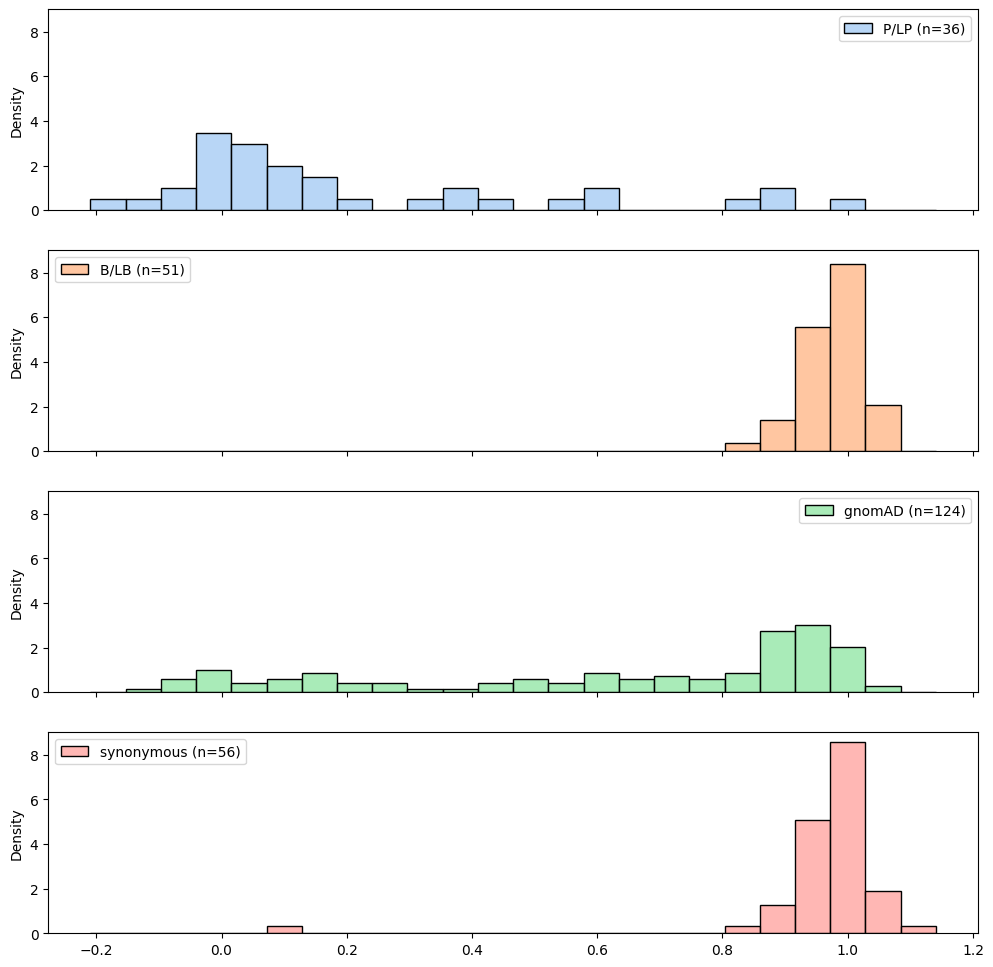

In [44]:
plotting.plot_samples({k : v.score.values for k,v in sample_data.items()})

In [45]:
pd.DataFrame.from_records([*[dict(sample_name='P/LP',score=score) for score in sample_data['P/LP'].score.values],
                            *[dict(sample_name='B/LB',score=score) for score in sample_data['B/LB'].score.values],
                            *[dict(sample_name='gnomAD',score=score) for score in sample_data['gnomAD'].score.values],
                            *[dict(sample_name='synonymous',score=score) for score in sample_data['synonymous'].score.values]]).to_csv(dataset_path / "samples.csv",index=False)